# Causal programming

## Joshua Brulé

## Opinions on causality

> Causality is simple.
> 
> —Judea Pearl

> Causal inference is still very difficult.
> 
> —Ilya Shpitser

## Lisp (Clojure)

Take a function call, `f(x, y)`, and move the paren one word to the left, `(f x y)`

In [2]:
(println "Hello")

Hello


In [11]:
(require '[acausal.core :as a :refer [defmodel model identifiable? identify p q data query]] :reload-all)
(require '[clojure.pprint :refer [pprint]])

## Model

A set of structural causal models; e.g. assume that the effect of smoking ($X$) on cancer ($Y$) is mediated by tar ($Z$). However, there may be a latent factor that affects both smoking and cancer:

$$ X = f_X(\epsilon_X) $$
$$ Z = f_Z(x, \epsilon_Z) $$
$$ Y = f_Y(z, \epsilon_Y) $$
$$ \epsilon_X \not\bot\!\!\bot \epsilon_Y$$

## Model

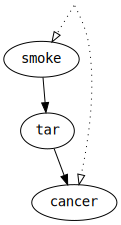

In [3]:
(defmodel pearl
    {:smoke []
     :tar [:smoke]
     :cancer [:tar]}
    #{:smoke :cancer})

In [12]:
(pprint
    (identify
        pearl
        (q [:cancer] :do [:smoke])))

{:sum
 {:prod
  #{{:sum
     {:prod
      #{{:p #{:smoke}, :given #{}}
        {:p #{:cancer}, :given #{:tar :smoke}}}},
     :sub #{:smoke}}
    {:numer {:sum {:p #{:tar :cancer :smoke}}, :sub #{:cancer}},
     :denom
     {:sub #{:tar},
      :sum {:sum {:p #{:tar :cancer :smoke}}, :sub #{:cancer}}}}}},
 :sub #{:tar}}


## Named variables

In [8]:
(def complex-model
    "A hypothetical model from (Someone, Important et. al. 1970)"
    (model
        {:elastin [:selectin]
         :collagen [:cadherin :nicotinic]
         :cadherin [:selectin :elastin]
         :selectin []
         :nicotinic [:selectin]}
        #{:selectin :elastin :collagen}
        #{:elastin :nicotinic}))

#'user/complex-model

## Causal diagram

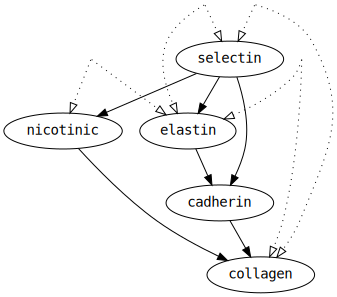

In [31]:
complex-model

## Query

A query from the causal hierarchy, e.g. $P(y \mid do(x))$

In [13]:
(q [:y] :do [:x])

#acausal.core.Query{:effect #{:y}, :do #{:x}}

## Data

A set of known population probabilities, e.g. $P(x, y, z)$

In [16]:
(p [:x :y :z])

#acausal.core.Data{:vars #{:y :z :x}, :surrogate #{}, :i-map nil}

## Identification

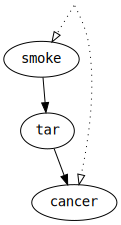

In [17]:
(def smoking-model
    "Model from (Pearl 1995)"
    (model
        {:smoke []
         :tar [:smoke]
         :cancer [:tar]}
        #{:smoke :cancer}))

smoking-model

## Identifiable?

In the smoking model, is $P(\text{cancer} \mid do(\text{smoke}))$ identifiable from $P(\text{smoke}, \text{tar}, \text{cancer})$ ?

In [18]:
(identifiable?
    smoking-model
    (q [:cancer] :do [:smoke])
    (p [:smoke :tar :cancer]))

true

## Identification

In [37]:
(identify
    smoking-model
    (q [:cancer] :do [:smoke]))

{:sub #{:tar},
 :sum
 {:prod
  #{{:p #{:cancer},
     :where
     {:sub #{:smoke},
      :sum
      {:p #{:cancer :smoke},
       :where
       {:prod
        #{{:p #{:smoke}, :given #{}}
          {:p #{:cancer}, :given #{:tar :smoke}}}}}}}
    {:where {:sub #{:cancer}, :sum {:p #{:tar :cancer :smoke}}},
     :p #{:tar},
     :given #{:smoke}}}}}


$\sum_{\text{tar}} P(\text{tar} \mid \text{smoke}) \sum_{\text{smoke}} P(\text{cancer} \mid \text{tar}, \text{smoke}) P(\text{smoke}) $

In [19]:
(def napkin
    "Napkin model"
    (model
        {:z_1 [:z_2]
         :x [:z_1]
         :y [:x]
         :z_2 []}
        #{:x :z_2}
        #{:z_2 :y}))

#'user/napkin

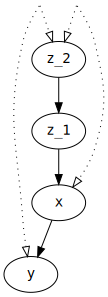

In [20]:
napkin

In [22]:
(identify
    napkin
    (q [:y] :do [:x]))

{:where
 {:sub #{:z_2},
  :sum
  {:p #{:y :z_2 :x},
   :where
   {:prod
    #{{:p #{:y}, :given #{:z_2 :z_1 :x}}
      {:p #{:x}, :given #{:z_2 :z_1}} {:p #{:z_2}, :given #{}}}}}},
 :p #{:y},
 :given #{:x}}


P'(y | x)

Where P'(x, y) = \sum_{z_2} P''(y, z_2, x)